In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import sns

In [31]:
from sklearn.preprocessing import MinMaxScaler

# Считывание данных
file_path = "../asset-2/data.csv"  # Путь к файлу out.csv
data = pd.read_csv(file_path, index_col='datetime', parse_dates=True)
scaler = MinMaxScaler()


# Подготовка данных
X = data.drop(columns=['rul', 'type_fail'])
y = data['rul']
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.values.reshape(-1, 1))

In [32]:
import numpy as np


# Подготовка временных окон для RNN
def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 8  # размер окна временных шагов
X_rnn, y_rnn = create_sequences(X, y, time_steps)
y = y[time_steps:]


In [33]:
import tensorflow as tf

# Определение модели
rnn_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(time_steps, X_rnn.shape[2])),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(1, activation='relu')
])

# Компиляция модели
rnn_model.compile(optimizer='adam', loss='mse')


In [34]:
history = rnn_model.fit(X_rnn, y_rnn, epochs=150, batch_size=5, validation_split=0.2, verbose=2)

Epoch 1/150
763/763 - 4s - 6ms/step - loss: 0.0628 - val_loss: 0.1571
Epoch 2/150
763/763 - 2s - 3ms/step - loss: 0.0431 - val_loss: 0.2447
Epoch 3/150
763/763 - 2s - 3ms/step - loss: 0.0270 - val_loss: 0.2434
Epoch 4/150
763/763 - 2s - 3ms/step - loss: 0.0160 - val_loss: 0.2039
Epoch 5/150
763/763 - 2s - 3ms/step - loss: 0.0132 - val_loss: 0.2527
Epoch 6/150
763/763 - 2s - 3ms/step - loss: 0.0107 - val_loss: 0.2711
Epoch 7/150
763/763 - 2s - 3ms/step - loss: 0.0092 - val_loss: 0.2365
Epoch 8/150
763/763 - 2s - 3ms/step - loss: 0.0096 - val_loss: 0.2070
Epoch 9/150
763/763 - 2s - 3ms/step - loss: 0.0088 - val_loss: 0.1835
Epoch 10/150
763/763 - 2s - 3ms/step - loss: 0.0117 - val_loss: 0.1107
Epoch 11/150
763/763 - 2s - 3ms/step - loss: 0.0089 - val_loss: 0.0971
Epoch 12/150
763/763 - 2s - 3ms/step - loss: 0.0068 - val_loss: 0.0920
Epoch 13/150
763/763 - 2s - 3ms/step - loss: 0.0148 - val_loss: 0.0870
Epoch 14/150
763/763 - 2s - 3ms/step - loss: 0.0084 - val_loss: 0.0870
Epoch 15/150
76

In [35]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = rnn_model.predict(X_rnn)
y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
y = scaler.inverse_transform(y.reshape(-1,1))

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [36]:
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
print(rmse)
print(r2)

328.76934515939456
0.7043899394642723


In [37]:
errors = y_pred - y;


C:\Users\lichuha\AppData\Local\Temp\ipykernel_18820\1060130863.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


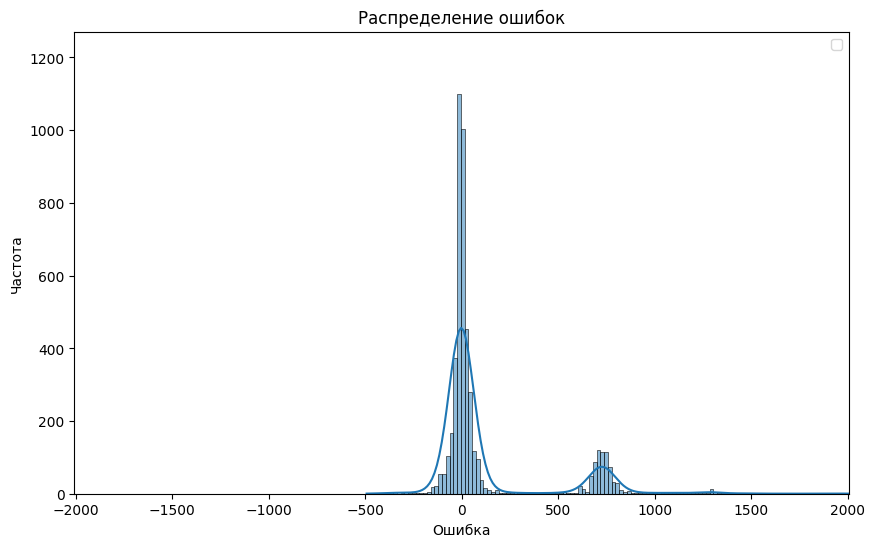

In [38]:
import seaborn as sns

# Визуализация распределения ошибок
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=128, kde=True)
plt.title('Распределение ошибок')
plt.xlabel('Ошибка')
plt.ylabel('Частота')
#plt.axvline(0, color='red', linestyle='--', label='0 (идеальное предсказание)')
plt.legend()

# Настройка диапазона графика
plt.xlim(-max(abs(errors)) - 1, max(abs(errors)) + 1)  # Устанавливаем диапазон
plt.ylim(0, plt.ylim()[1] * 1.1)  # Увеличиваем максимальную частоту на 10%
plt.show()



In [39]:
from scipy.stats import stats

normal_distribution: np.ndarray = np.random.normal(0, 0.1, 1000)
# Проверка нормальности с использованием теста Колмогорова-Смирнова
ks_test = stats.kstest(errors, 'norm', args=(np.mean(errors), np.std(errors)))
print(f"Статистика теста Колмогорова-Смирнова: {ks_test.statistic}, p-value: {ks_test.pvalue}")

# Вычисление границ, если распределение ненормальное
if ks_test.pvalue <= 0.05:
    print('Ненормальное')
    percentiles = [90, 95, 99]
    boundaries = {percentile: np.percentile(errors, percentile) for percentile in percentiles}
    print("Границы ошибок для избегания:")
    for percentile, boundary in boundaries.items():
        print(f"{percentile}%: {boundary:.4f}")
else:
    print('Нормальное')
    confidence_levels = [0.90, 0.95, 0.99]
    critical_values = {alpha: stats.norm.ppf(alpha) for alpha in confidence_levels}
    print("Критические значения для уровня значимости:")
    for alpha, value in critical_values.items():
        print(f"{alpha}: {value:.4f}")

Статистика теста Колмогорова-Смирнова: [0.36195891], p-value: [0.]
Ненормальное
Границы ошибок для избегания:
90%: 715.9725
95%: 757.0986
99%: 1198.1289


C:\Users\lichuha\AppData\Local\Temp\ipykernel_18820\1015646420.py:5: DeprecationWarning: Please import `kstest` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  ks_test = stats.kstest(errors, 'norm', args=(np.mean(errors), np.std(errors)))


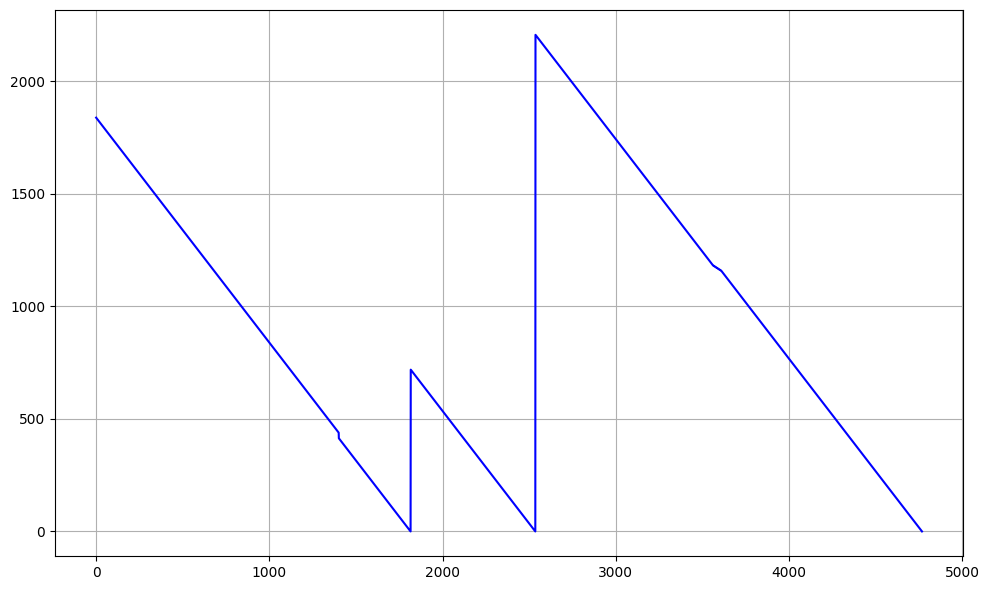

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(y, linestyle='-', color='b')
plt.grid(True)
plt.tight_layout()
plt.show()

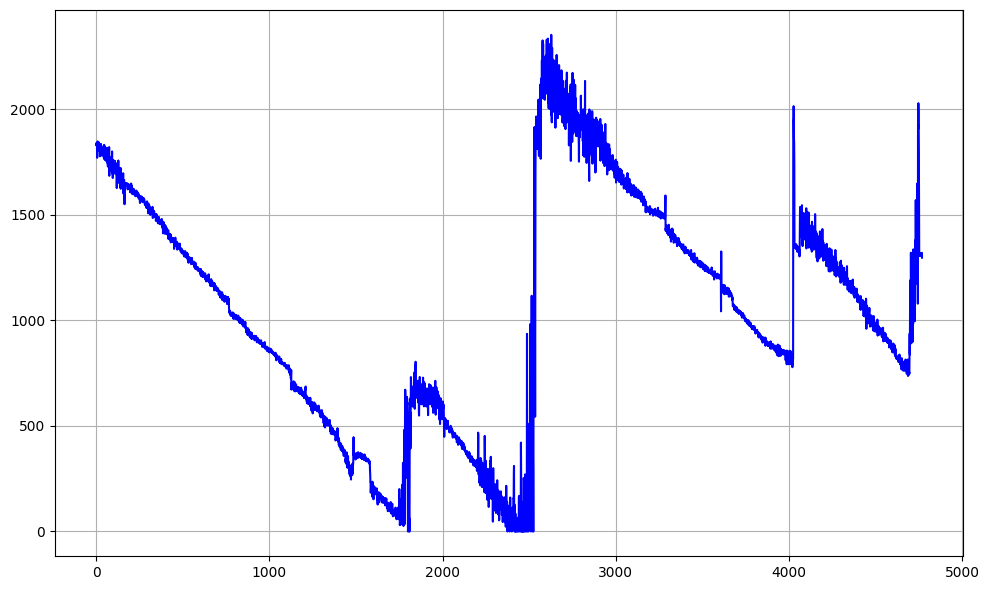

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(y_pred, linestyle='-', color='b')
plt.grid(True)
plt.tight_layout()
plt.show()